# **Imports**

In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import tensorflow as tf
import cv2

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU
import shutil
import random
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Enable Mixed Precision Training (AMP)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [3]:
# Enable XLA Compilation for additional speedup
tf.config.optimizer.set_jit(True)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading the Dataset**

In [7]:
# Defining the dataset directories
train_dir = '/content/drive/My Drive/Skin_1000_dataset/skin types/train'
val_dir = '/content/drive/My Drive/Skin_1000_dataset/skin types/valid'
test_dir = '/content/drive/My Drive/Skin_1000_dataset/skin types/test'


In [8]:
# this function is to count the images in the directory
def count_images(directory):
    return sum(len(files) for _, _, files in os.walk(directory))

# Counting the images in the train directory
train_oily_count = count_images(os.path.join(train_dir, 'oily'))
train_dry_count = count_images(os.path.join(train_dir, 'dry'))
train_normal_count = count_images(os.path.join(train_dir, 'normal'))

# Counting the images in the test directory
test_oily_count = count_images(os.path.join(test_dir, 'oily'))
test_dry_count = count_images(os.path.join(test_dir, 'dry'))
test_normal_count = count_images(os.path.join(test_dir, 'normal'))

# Counting the images in the valid directory
valid_oily_count = count_images(os.path.join(val_dir, 'oily'))
valid_dry_count = count_images(os.path.join(val_dir, 'dry'))
valid_normal_count = count_images(os.path.join(val_dir, 'normal'))

# Printing the counts
print(f"Train Oily Images: {train_oily_count}")
print(f"Train Dry Images: {train_dry_count}")
print(f"Train Normal Images: {train_normal_count}")
print("-----------------------------------------------------")
print(f"Test Oily Images: {test_oily_count}")
print(f"Test Dry Images: {test_dry_count}")
print(f"Test Normal Images: {test_normal_count}")
print("-----------------------------------------------------")
print(f"valid Oily Images: {valid_oily_count}")
print(f"valid Dry Images: {valid_dry_count}")
print(f"vali Normal Images: {valid_normal_count}")

Train Oily Images: 450
Train Dry Images: 270
Train Normal Images: 333
-----------------------------------------------------
Test Oily Images: 15
Test Dry Images: 10
Test Normal Images: 18
-----------------------------------------------------
valid Oily Images: 34
valid Dry Images: 25
vali Normal Images: 28


# **Visualizing the class distribution in the training dataset**

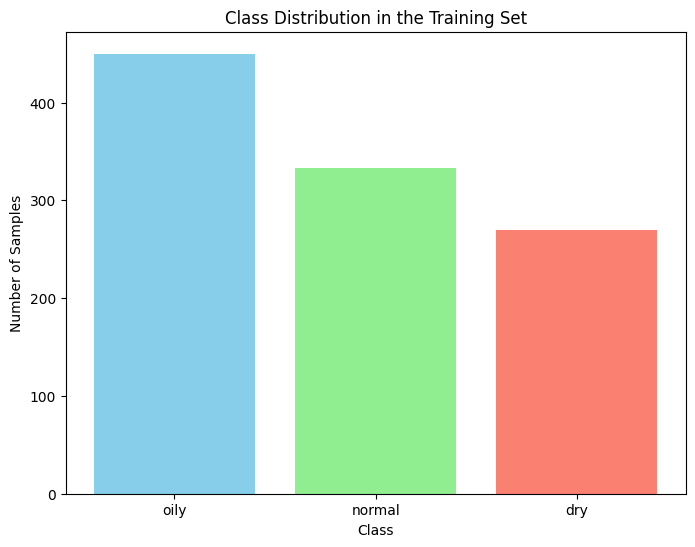

In [9]:
# Getting the class names (the folders) and filter out any hidden directories
class_names = [folder for folder in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, folder))]

# Initializing an empty list to carry the class counts
class_counts = []

# Looping through each class folder and count the number of images
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_count = len(os.listdir(class_path))  # Number of images in the class folder
        class_counts.append(class_count)

# Plotting the class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_names, class_counts, color=['skyblue', 'lightgreen', 'salmon'])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in the Training Set')
plt.show()

# **Balancing the Training classes using Oversampling**

In [10]:
# Define the directories
dry_dir = os.path.join(train_dir, "dry")
normal_dir = os.path.join(train_dir, "normal")

# Define target count (same as Oily: 450 images)
target_count = 450

def oversample_images(class_dir, target_count):
    images = os.listdir(class_dir)
    current_count = len(images)

    while len(os.listdir(class_dir)) < target_count:
        img_to_copy = random.choice(images)
        img_path = os.path.join(class_dir, img_to_copy)
        new_img_path = os.path.join(class_dir, f"copy_{len(os.listdir(class_dir))}_{img_to_copy}")
        shutil.copy(img_path, new_img_path)

# Oversample Dry and Normal classes
oversample_images(dry_dir, target_count)
oversample_images(normal_dir, target_count)

print("Oversampling complete!")


Oversampling complete!


# **Displaying the class counts after the oversampling**

In [11]:
# this function is to count the images in the directory
def count_images(directory):
    return sum(len(files) for _, _, files in os.walk(directory))

# Count images in the train directory
train_oily_count = count_images(os.path.join(train_dir, 'oily'))
train_dry_count = count_images(os.path.join(train_dir, 'dry'))
train_normal_count = count_images(os.path.join(train_dir, 'normal'))

# Count images in the test directory
test_oily_count = count_images(os.path.join(test_dir, 'oily'))
test_dry_count = count_images(os.path.join(test_dir, 'dry'))
test_normal_count = count_images(os.path.join(test_dir, 'normal'))

# Count images in the valid directory
valid_oily_count = count_images(os.path.join(val_dir, 'oily'))
valid_dry_count = count_images(os.path.join(val_dir, 'dry'))
valid_normal_count = count_images(os.path.join(val_dir, 'normal'))

# Print the counts
print(f"Train Oily Images: {train_oily_count}")
print(f"Train Dry Images: {train_dry_count}")
print(f"Train Normal Images: {train_normal_count}")
print("-----------------------------------------------------")
print(f"Test Oily Images: {test_oily_count}")
print(f"Test Dry Images: {test_dry_count}")
print(f"Test Normal Images: {test_normal_count}")
print("-----------------------------------------------------")
print(f"valid Oily Images: {valid_oily_count}")
print(f"valid Dry Images: {valid_dry_count}")
print(f"vali Normal Images: {valid_normal_count}")

Train Oily Images: 450
Train Dry Images: 450
Train Normal Images: 450
-----------------------------------------------------
Test Oily Images: 15
Test Dry Images: 10
Test Normal Images: 18
-----------------------------------------------------
valid Oily Images: 34
valid Dry Images: 25
vali Normal Images: 28


# **Merging the Validation the Test Sets**
## we need to copy all the images from the valid set into the test set to merge them.

In [12]:
# Looping through each class folder in the validation set
for class_name in os.listdir(val_dir):
    val_class_path = os.path.join(val_dir, class_name)
    test_class_path = os.path.join(test_dir, class_name)

    # Skipping the non directory files
    if not os.path.isdir(val_class_path):
        continue

    # Ensuring that the test folder exists
    os.makedirs(test_class_path, exist_ok=True)

    # Moving all the images from the validation set to the testing set
    for img_name in os.listdir(val_class_path):
        src_path = os.path.join(val_class_path, img_name)
        dest_path = os.path.join(test_class_path, img_name)

        # Checking if it's an actual file before moving
        if os.path.isfile(src_path):
            shutil.move(src_path, dest_path)

    print(f"Moved {len(os.listdir(test_class_path))} images to {test_class_path}")

print("Validation set merged into the test set successfully!")

Moved 49 images to /content/drive/My Drive/Skin_1000_dataset/skin types/test/oily
Moved 46 images to /content/drive/My Drive/Skin_1000_dataset/skin types/test/normal
Moved 35 images to /content/drive/My Drive/Skin_1000_dataset/skin types/test/dry
Validation set merged into the test set successfully!


# **Displaying the class counts after merging the test and the validation sets together**

In [13]:
# this function is to count the images in the directory
def count_images(directory):
    return sum(len(files) for _, _, files in os.walk(directory))

# Counting the images in the train directory
train_oily_count = count_images(os.path.join(train_dir, 'oily'))
train_dry_count = count_images(os.path.join(train_dir, 'dry'))
train_normal_count = count_images(os.path.join(train_dir, 'normal'))

# Counting the images in the test directory
test_oily_count = count_images(os.path.join(test_dir, 'oily'))
test_dry_count = count_images(os.path.join(test_dir, 'dry'))
test_normal_count = count_images(os.path.join(test_dir, 'normal'))

# Counting the images in the valid directory
valid_oily_count = count_images(os.path.join(val_dir, 'oily'))
valid_dry_count = count_images(os.path.join(val_dir, 'dry'))
valid_normal_count = count_images(os.path.join(val_dir, 'normal'))

# Printing the counts
print(f"Train Oily Images: {train_oily_count}")
print(f"Train Dry Images: {train_dry_count}")
print(f"Train Normal Images: {train_normal_count}")
print("-----------------------------------------------------")
print(f"Test Oily Images: {test_oily_count}")
print(f"Test Dry Images: {test_dry_count}")
print(f"Test Normal Images: {test_normal_count}")
print("-----------------------------------------------------")
print(f"valid Oily Images: {valid_oily_count}")
print(f"valid Dry Images: {valid_dry_count}")
print(f"vali Normal Images: {valid_normal_count}")

Train Oily Images: 450
Train Dry Images: 450
Train Normal Images: 450
-----------------------------------------------------
Test Oily Images: 49
Test Dry Images: 35
Test Normal Images: 46
-----------------------------------------------------
valid Oily Images: 0
valid Dry Images: 0
vali Normal Images: 0


# **The code of the K- Fold Cross Validation and fine tuning the pretrained VGG16 Model**

In [ ]:
# Getting only the class folders (dry, normal, oily) and ignore the non directory files
class_names = sorted(
    [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
)

class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}
idx_to_class = {v: k for k, v in class_to_idx.items()}  

image_paths = []
labels = []

# Getting the images paths and their corresponding labels
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        if os.path.isfile(img_path):  
            image_paths.append(img_path)
            labels.append(class_to_idx[class_name])

image_paths = np.array(image_paths)
labels = np.array(labels)

# Defining the K-Fold Cross Validation
k = 5  # The number of the folds
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# The Image data generator
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.15,
    shear_range=0.15,
    fill_mode='nearest'
)

# Looping over each fold
fold_no = 1
for train_idx, val_idx in skf.split(image_paths, labels):
    print(f"\nTraining Fold {fold_no}/{k}...")

    # Splitting the data
    train_paths, val_paths = image_paths[train_idx], image_paths[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    # Converting the integer labels to class names
    train_labels_str = [idx_to_class[label] for label in train_labels]
    val_labels_str = [idx_to_class[label] for label in val_labels]

    # Creating the dataframes
    train_df = pd.DataFrame({'filename': train_paths, 'class': train_labels_str})
    val_df = pd.DataFrame({'filename': val_paths, 'class': val_labels_str})

    # Creating the data generators for each fold
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    val_generator = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    # Loading the VGG16 model with its pre trained weights
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freezing all the convolutional base layers
    for layer in base_model.layers:
        layer.trainable = False

    # Adding my custom layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.002), dtype='float32')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.002), dtype='float32')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)
    predictions = Dense(3, activation='softmax', dtype='float32')(x)

    # Defining the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compiling the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Training the model for the fold
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,
        steps_per_epoch=len(train_generator),
        validation_steps=len(val_generator)
    )

    fold_no += 1


🔹 Training Fold 1/5...
Found 1080 validated image filenames belonging to 3 classes.
Found 270 validated image filenames belonging to 3 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 438s 12s/step - accuracy: 0.3273 - loss: 2.9141 - val_accuracy: 0.4667 - val_loss: 2.6858
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 29s 638ms/step - accuracy: 0.5121 - loss: 2.4858 - val_accuracy: 0.5556 - val_loss: 2.4017
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 620ms/step - accuracy: 0.5392 - loss: 2.4106 - val_accuracy: 0.5815 - val_loss: 2.3151
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 653ms/step - accuracy: 0.5974 - loss: 2.2441 - val_accuracy: 0.6111 - val_loss: 2.2593
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 621ms/step - accuracy: 0.5947 - loss: 2.2481 - val_accuracy: 0.6407 - val_loss: 2.1807
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 42s 659ms/step - accuracy: 0.6246 - loss: 2.1411 - val_accuracy: 0.6333 - val_loss: 2.1136
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 639ms/step - accuracy: 0.6368 - loss: 2.1348 - val_accuracy: 0.7000 - val_loss: 2.0761
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 662ms/step - accuracy: 0.6812 - loss: 2.0453 - val_accur

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 776ms/step - accuracy: 0.3921 - loss: 2.7685 - val_accuracy: 0.4148 - val_loss: 3.3707
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 651ms/step - accuracy: 0.5308 - loss: 2.4684 - val_accuracy: 0.5333 - val_loss: 2.5220
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 654ms/step - accuracy: 0.5605 - loss: 2.3171 - val_accuracy: 0.5370 - val_loss: 2.4506
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 646ms/step - accuracy: 0.5783 - loss: 2.2415 - val_accuracy: 0.5815 - val_loss: 2.2952
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 614ms/step - accuracy: 0.6285 - loss: 2.2104 - val_accuracy: 0.6000 - val_loss: 2.2481
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 42s 639ms/step - accuracy: 0.6426 - loss: 2.1380 - val_accuracy: 0.6296 - val_loss: 2.1573
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 635ms/step - accuracy: 0.6469 - loss: 2.0808 - val_accuracy: 0.6593 - val_loss: 2.1029
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 42s 676ms/step - accuracy: 0.6691 - loss: 2.0790 - val_accu

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 754ms/step - accuracy: 0.3988 - loss: 2.8328 - val_accuracy: 0.4037 - val_loss: 3.1054
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 613ms/step - accuracy: 0.5151 - loss: 2.5249 - val_accuracy: 0.5222 - val_loss: 2.4437
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 647ms/step - accuracy: 0.5710 - loss: 2.3241 - val_accuracy: 0.5630 - val_loss: 2.3886
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 657ms/step - accuracy: 0.5772 - loss: 2.2752 - val_accuracy: 0.5630 - val_loss: 2.2538
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 637ms/step - accuracy: 0.5890 - loss: 2.2024 - val_accuracy: 0.5815 - val_loss: 2.2123
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 663ms/step - accuracy: 0.6117 - loss: 2.1708 - val_accuracy: 0.6000 - val_loss: 2.1276
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 647ms/step - accuracy: 0.6717 - loss: 2.0438 - val_accuracy: 0.6407 - val_loss: 2.1163
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 628ms/step - accuracy: 0.6580 - loss: 2.0477 - val_accu

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 763ms/step - accuracy: 0.3735 - loss: 2.8897 - val_accuracy: 0.5370 - val_loss: 2.6379
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 651ms/step - accuracy: 0.5048 - loss: 2.5077 - val_accuracy: 0.4963 - val_loss: 2.5577
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 42s 669ms/step - accuracy: 0.5084 - loss: 2.4335 - val_accuracy: 0.5815 - val_loss: 2.3736
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 642ms/step - accuracy: 0.5886 - loss: 2.2333 - val_accuracy: 0.5926 - val_loss: 2.2404
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 643ms/step - accuracy: 0.6268 - loss: 2.2080 - val_accuracy: 0.6000 - val_loss: 2.1822
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 654ms/step - accuracy: 0.6411 - loss: 2.1240 - val_accuracy: 0.6259 - val_loss: 2.1798
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 644ms/step - accuracy: 0.6483 - loss: 2.1084 - val_accuracy: 0.6778 - val_loss: 2.0337
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 615ms/step - accuracy: 0.6677 - loss: 2.1102 - val_accu

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 30s 717ms/step - accuracy: 0.3715 - loss: 2.8478 - val_accuracy: 0.4704 - val_loss: 2.7984
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 637ms/step - accuracy: 0.4738 - loss: 2.5159 - val_accuracy: 0.5852 - val_loss: 2.4372
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 647ms/step - accuracy: 0.5506 - loss: 2.3641 - val_accuracy: 0.5963 - val_loss: 2.3059
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 609ms/step - accuracy: 0.5731 - loss: 2.2409 - val_accuracy: 0.5852 - val_loss: 2.2762
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 643ms/step - accuracy: 0.6243 - loss: 2.2194 - val_accuracy: 0.6630 - val_loss: 2.1035
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 626ms/step - accuracy: 0.6346 - loss: 2.1049 - val_accuracy: 0.6630 - val_loss: 2.0744
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 42s 657ms/step - accuracy: 0.6716 - loss: 2.0916 - val_accuracy: 0.7037 - val_loss: 2.0785
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 652ms/step - accuracy: 0.6678 - loss: 2.0691 - val_accu

In [ ]:
# Defining the test generator
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important: No shuffling for test set
)

Found 130 images belonging to 3 classes.


# **Evaluating the model**

In [18]:
# Printing the test accuracy:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 67s 17s/step - accuracy: 0.7897 - loss: 1.7484
Test Accuracy: 0.7923076748847961


# **Plotting the training and validation loss and Acuracies**

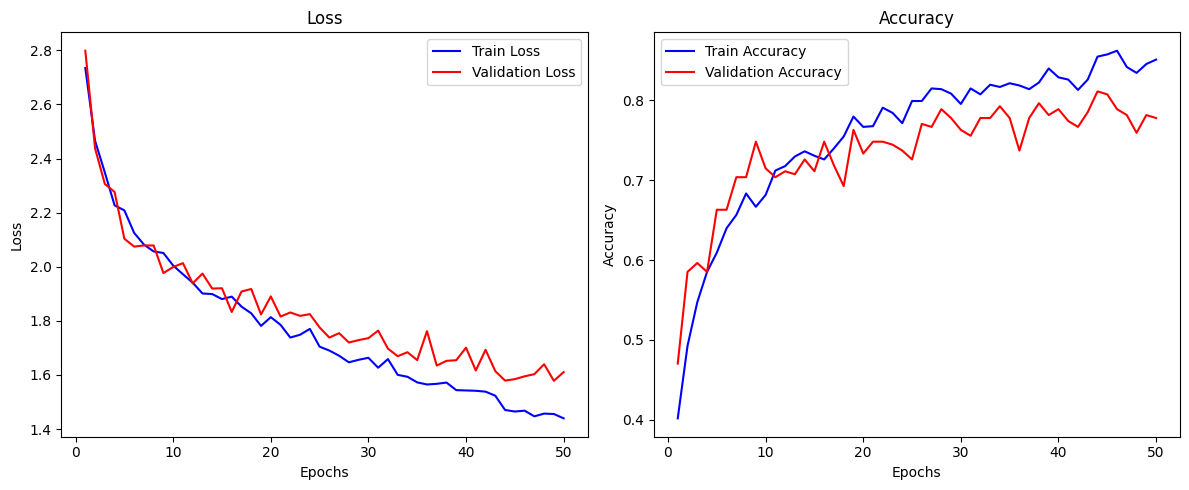

In [19]:
# Extracting the loss and the accuracy from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Creating the subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plotting the Loss
axes[0].plot(epochs, train_loss, label='Train Loss', color='blue')
axes[0].plot(epochs, val_loss, label='Validation Loss', color='red')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plotting the Accuracy
axes[1].plot(epochs, train_acc, label='Train Accuracy', color='blue')
axes[1].plot(epochs, val_acc, label='Validation Accuracy', color='red')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# Show plot
plt.tight_layout()
plt.show()

# **Observations**
### The Loss Curves shows that both the training loss (the blue line) and the validation loss (the red line) are decreasing over epochs which indicates that the model is learning.

### The accuracy curves shows that both the training accuracy (the blue line) and the validation accuracy (the red line) are increase over time.

### Both the loss and the accuracy curves showing that the model has a good performance

# **Printing the classification Report**

In [20]:
# Getting the true labels and the predictions for the test dataset
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Getting the class names
class_labels = list(test_generator.class_indices.keys())

# Printing the classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step
              precision    recall  f1-score   support

         dry       0.73      0.77      0.75        35
      normal       0.86      0.80      0.83        46
        oily       0.78      0.80      0.79        49

    accuracy                           0.79       130
   macro avg       0.79      0.79      0.79       130
weighted avg       0.79      0.79      0.79       130



# **Observation**
### The Model achieved an accuracy of 79%.
### The best performance of the model is on the "Normal skin" class (the Precision=0.86, the Recall=0.80, and the F1-score=0.83
### And the Weakest Performance is on the "Dry skin" class (the Precision=0.73, the Recall=0.77, and the F1-score=0.75)
### The Macro and the Weighted Averages (F1-score = 0.79) which shows that the performance of the model is fairly balanced across all the classes.
### The model performance is overall good but also it could be improved especially in the classification of the dry skin.

# **Printing the Confusion Matrix**  

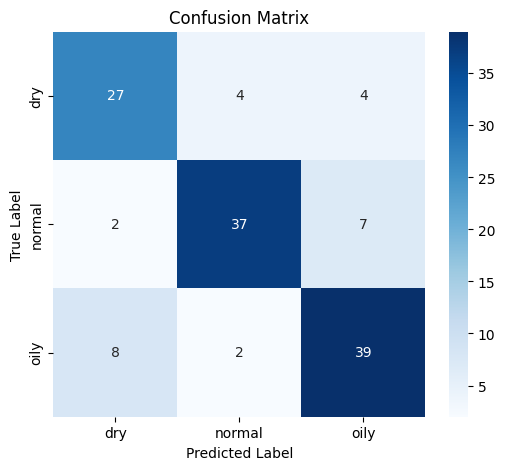

In [21]:
# Computing the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plottin the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# The Labels and the title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# **Observation**
### The model classified 27 "Dry" skin images from 35 images (There are 4 misclassified images as "Normal" skin and 4 misclassified imagesas "Oily").
### It also classified 37 "Normal" skin images from 46 images (There are 2 misclassified images as "Dry" skinand 7 misclassified imagesas "Oily").
### It also classified 39 "Oily" skin images from 49 images (There are 8 misclassified images as "Dry" skinand 2 misclassified imagesas "Normal").
### This shows that the missclassifications between the "Dry" class and the "Oily" class is relatively high (8 images) and the "Normal" skin is the most accurately classified class.

# **Saving the Model**

In [ ]:
# # Saving the model as .keras
# from tensorflow.keras.models import save_model

# # Saving the entire model
# model.save('/content/drive/My Drive/Skin_1000_dataset/Best_Accuracy_Skin_Classification_Model.keras')
# # Saving the model as .h5
# # Saving the entire model
# model.save('/content/drive/My Drive/Skin_1000_dataset/Best_Accuracy_Skin_Classification_Model.h5')

# **Loading the model**

In [28]:
# Defining the custom Cast layer
class Cast(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Cast, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.cast(inputs, tf.float32)

# Creating the custom objects dictionary including the LeakyReLU
custom_objects = {
    'Cast': Cast,
    'LeakyReLU': tf.keras.layers.LeakyReLU
}

# Loading the model with the custom objects
loaded_model = load_model(
    'Best_Accuracy_Skin_Classification_Model.h5',
    custom_objects=custom_objects
)

# **Printing the classification report of the loaded model**

In [29]:
# Getting the true labels and the predictions of the test data
y_true = test_generator.classes
y_pred_probs = loaded_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Getting the class names
class_labels = list(test_generator.class_indices.keys())

# Printing the classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 378ms/step
              precision    recall  f1-score   support

         dry       0.73      0.77      0.75        35
      normal       0.86      0.80      0.83        46
        oily       0.78      0.80      0.79        49

    accuracy                           0.79       130
   macro avg       0.79      0.79      0.79       130
weighted avg       0.79      0.79      0.79       130

